## Classification
Notebook to evaluate efficacy of classification between different thalamic cell type groups

In [2]:
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import scipy.io
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestCentroid
import pickle
import json

### To do:
1) Benchmark simple Wilcoxon selection, for various sizes of gene panels
2) Benchmark w/ and w/o absolute values

In [3]:
# Load in pre-processed data from glutamatergic class designation, subclass to all rank_gene_groups already performed
gluData = sc.read("../Data/gluData.h5ad")

C:\Users\mathew.summers\Anaconda3\envs\scanpy1.9\lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
# Acquire genes
def getUniqueGenes(geneDict, perClass = 1):
    """ Function to find X number of genes per class for a given gene dictionary, and assemble them
    into a list of unique genes. """
    import numpy as np
    
    keyNames = list(geneDict.keys())
    if perClass > len(geneDict[keyNames[0]]):
        print("Requested genes per class greater than number contained within first dict element - using that instead.")
        perClass = len(geneDict[keyNames[0]])
    
    geneList = []
    for name in keyNames:
        geneList.append(geneDict[name][0:perClass])
        
    geneList = np.unique(geneList)
    return geneList

In [5]:
def evalPanel(geneData,genePanel,cluster, showPlot = True):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Plot confusion matrix if requested
    if showPlot:
        confMatrix = confusion_matrix(cluster,assignedCluster)
        sortIndx = np.argsort(np.diagonal(-confMatrix)) # sort descending from cluster w/ highest overall accuracy
        ax = sns.heatmap(confMatrix.iloc[sortIndx,sortIndx])
        ax.set(title="Classification Accuracy: %1.1f%%" %round(accuracy*100,2))
        ax.set(ylabel="Original Label")
        ax.set(xlabel = "Assigned Label")
        return accuracy, ax
    else:
        return accuracy

In [6]:
# Create a super list dictionary of top marker genes for each subclass, which can be later indexed for specific gene panels
markerGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts_rest"][indx][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:500,:]
    genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False)
    markerGenes[indx] = genesFiltered["names"][0:32].tolist()

In [7]:
# Assemble a dictionary w/ varying length gene panels
panelWilcoxon = {}
panelIDs = [1, 2, 3, 4, 8, 16, 32]
for i in panelIDs:
    panelWilcoxon[i] = getUniqueGenes(markerGenes,i)

In [7]:
panelWilcoxon[32]

array(['1700011I03Rik', '9330158H04Rik', 'A330049N07Rik', 'AF529169',
       'AI504432', 'AW551984', 'Abhd12b', 'Acvr1c', 'Adamts15', 'Adra1a',
       'Adra1b', 'Adra2a', 'Ankfn1', 'Ano1', 'Ano3', 'Arhgef26',
       'Arhgef5', 'Atp2b4', 'Baiap2', 'Baiap3', 'Barhl2', 'Bcl11b',
       'Bcl2l11', 'Bhlhe22', 'Bmper', 'C130026L21Rik', 'C1ql2', 'C1ql3',
       'Cacna1i', 'Cacng3', 'Cacng5', 'Caln1', 'Car4', 'Cbln1', 'Cbln2',
       'Cbln4', 'Ccnd1', 'Cdc14a', 'Cdh9', 'Cemip', 'Chrm1', 'Chrna3',
       'Chrnb4', 'Cmtm7', 'Cmtm8', 'Cmya5', 'Cnih3', 'Cnksr3', 'Cnr1',
       'Cntnap3', 'Col11a1', 'Col27a1', 'Col8a1', 'Cplx2', 'Cpne5',
       'Cpne8', 'Ctxn1', 'Ctxn3', 'Cwh43', 'Cygb', 'D030068K23Rik',
       'D130009I18Rik', 'D130079A08Rik', 'Dach1', 'Dchs2', 'Dgkg', 'Dkk3',
       'Dlgap2', 'Dnah9', 'Doc2b', 'Dpf3', 'Dpy19l1', 'Dscaml1', 'Ebf1',
       'Echdc2', 'Eepd1', 'Efnb3', 'Elfn1', 'Epha8', 'Ephb1', 'Eps8l2',
       'Erbb4', 'Fam163a', 'Fam189a2', 'Fam19a4', 'Fam20a', 'Fam46a',
       'F

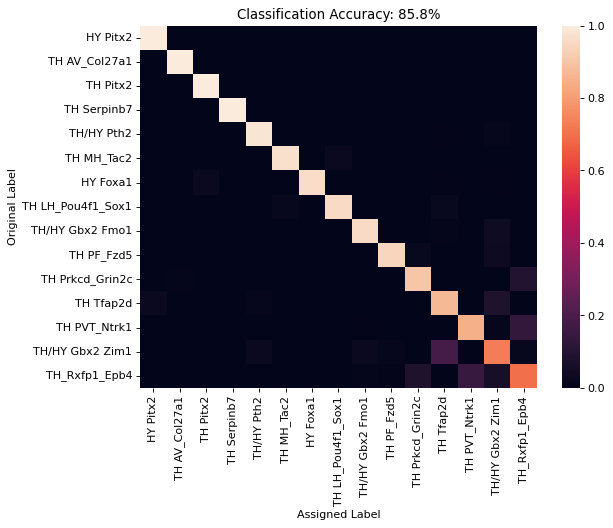

In [8]:
# Check how a particular gene panel does w/ confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
evalPanel(gluData,panelWilcoxon[32],gluData.obs["subclass_label"],True);

Text(0.5, 1.0, 'Gene Panel Efficacy: Wilcoxon Method')

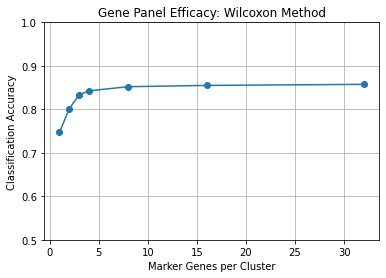

In [7]:
# Systematically evaluate gene panels
wilAccuracy = [evalPanel(gluData,panelWilcoxon[i],gluData.obs["subclass_label"],False) for i in panelIDs]
# Plot results
fig, ax = plt.subplots()
plt.plot(panelIDs,wilAccuracy,'o-')
ax.set_ylim(0.5, 1)
plt.grid()
plt.xlabel("Marker Genes per Cluster")
plt.ylabel("Classification Accuracy")
plt.title("Gene Panel Efficacy: Wilcoxon Method")

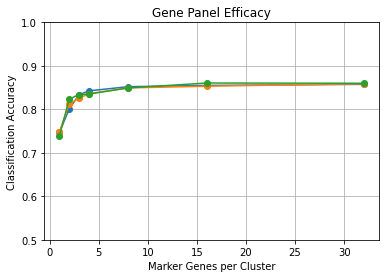

In [609]:
# Plot results w/ several different ranking methods - largely similar result
ax.plot(panelIDs,panelAccuracy,'o-')
fig

## Compare gene selectors
Use gene panels provided by Wilcoxon rank testing, scGeneFit, PROPOSE (in progress)

In [18]:
# Needs cleaning up
gfDict = {15 : list(gfPanel['1']), 30 : list(gfPanel['2']), 60 : list(gfPanel['4']), 500 : list(gfPanel['32'])}
prDict = prPanel

with open("../Data/Gene Panels/PROPOSE_subclass_genes.json", "w") as f:
    json.dump(prDict, f, indent=4)
    
with open("../Data/Gene Panels/scGeneFit_subclass_genes.json", "w") as f:
    json.dump(gfDict, f, indent=4)

In [17]:
with open("../Data/subclass_marker_genes_scGeneFit.pickle", "rb") as f:
    gfPanel = pickle.load(f)

In [8]:
with open("../Data/Gene Panels/scGeneFit_subclass_genes.json", "r") as f:
    gfPanel = json.load(f)
    
with open("../Data/Gene Panels/PROPOSE_subclass_genes.json", "r") as f:
    prPanel = json.load(f)
    
with open("../Data/Gene Panels/activeSVM_subclass_genes.json", "r") as f:
    svPanel = json.load(f)

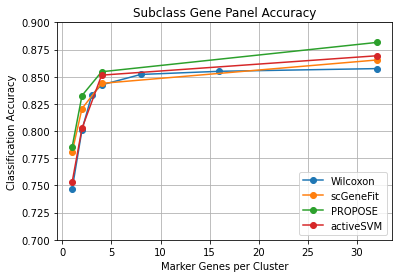

In [11]:
# Systematically evaluate gene panels
gfAccuracy = [evalPanel(gluData,gfPanel[i],gluData.obs["subclass_label"],False) for i in gfPanel.keys()]
prAccuracy = [evalPanel(gluData,prPanel[i],gluData.obs["subclass_label"],False) for i in prPanel.keys()]
svAccuracy = [evalPanel(gluData,svPanel[i],gluData.obs["subclass_label"],False) for i in svPanel.keys()]
# Plot results
fig, ax = plt.subplots()
ax.plot(panelIDs,wilAccuracy,'o-',label="Wilcoxon")
ax.plot([1, 2, 4, 32],gfAccuracy,'o-', label="scGeneFit")
ax.plot([1, 2, 4, 32],prAccuracy,'o-', label="PROPOSE")
ax.plot([1, 2, 4, 32],svAccuracy,'o-', label="activeSVM")
ax.set_ylim(0.7, .9)
plt.grid()
plt.xlabel("Marker Genes per Subclass")
plt.ylabel("Classification Accuracy")
plt.title("Subclass Gene Panel Accuracy")
plt.legend()

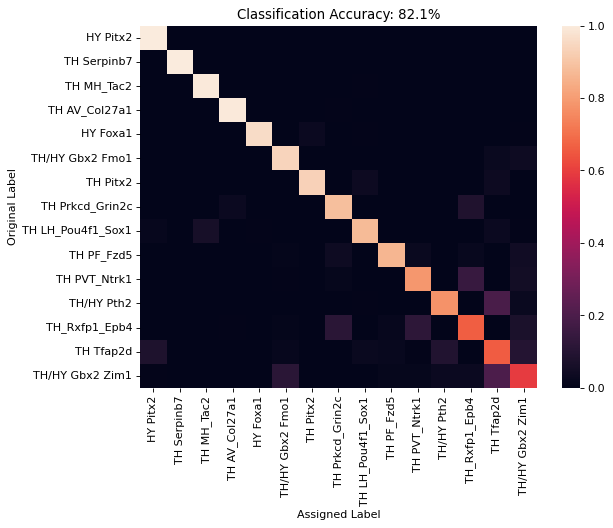

In [186]:
# Check how a particular gene panel does w/ confusion matrix
plt.figure(figsize=(8, 6), dpi=80)
plt.subplot
a, b, c = evalPanel(gluData,gfPanel["2"],gluData.obs["subclass_label"],True);

In [189]:
c

New Labels,HY Foxa1,HY Pitx2,TH AV_Col27a1,TH LH_Pou4f1_Sox1,TH MH_Tac2,TH PF_Fzd5,TH PVT_Ntrk1,TH Pitx2,TH Prkcd_Grin2c,TH Serpinb7,TH Tfap2d,TH/HY Gbx2 Fmo1,TH/HY Gbx2 Zim1,TH/HY Pth2,TH_Rxfp1_Epb4
subclass_label,,,,,,,,,,,,,,,
HY Foxa1,0.958824,0.000000,0.000000,0.005882,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,0.000000,0.000000,0.005882,0.000000,0.000000
HY Pitx2,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TH AV_Col27a1,0.000000,0.000000,0.994686,0.000000,0.000000,0.000000,0.000000,0.000000,0.005314,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
TH LH_Pou4f1_Sox1,0.005201,0.016345,0.000000,0.874443,0.061664,0.000000,0.000000,0.002229,0.000000,0.000000,0.031204,0.000743,0.004458,0.003715,0.000000
TH MH_Tac2,0.000000,0.000000,0.000000,0.004540,0.994779,0.000000,0.000000,0.000000,0.000000,0.000000,0.000454,0.000000,0.000000,0.000227,0.000000
TH PF_Fzd5,0.000400,0.000400,0.000000,0.000400,0.000000,0.861600,0.024800,0.000000,0.035200,0.000000,0.000800,0.008400,0.044400,0.001200,0.022400
TH PVT_Ntrk1,0.000000,0.000000,0.000185,0.000000,0.000000,0.000000,0.786492,0.000000,0.012918,0.000000,0.000000,0.006828,0.047979,0.000000,0.145599
TH Pitx2,0.000000,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.933333,0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000
TH Prkcd_Grin2c,0.000000,0.000000,0.030990,0.000000,0.000043,0.000171,0.002140,0.000000,0.883914,0.000300,0.000000,0.000000,0.000171,0.000000,0.082270


## Cluster size vs accuracy comparison

In [44]:
def plotClusterSize(geneData,genePanel,cluster):
    """ Function to plot gene panel accuracy as function of cluster size """
    from sklearn.neighbors import NearestCentroid
    import matplotlib.pyplot as plt
    
    # Get size of each cluster
    clTypes = cluster.unique()
    clCounts = pd.Series([sum(cluster == name) for name in clTypes], index = clTypes, name="Count")
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
  
    # Get accuracy for each cluster type
    clAcc = pd.Series( name = "Accuracy")
    for name in clTypes:
        clIndx = cluster == name
        clAcc[name] = nn.score(projGenes[clIndx,:],cluster[clIndx])

    results = clCounts.to_frame().join(clAcc).sort_values(by = "Accuracy", ascending=False)
    
    # Plot correlation between cluster size and accuracy
    fig, ax = plt.subplots()
    plt.plot(clCounts,clAcc,'or',markeredgecolor='k')
    ax.set_ylim(-0.02, 1.02)
    plt.grid()
    plt.xlabel("Cluster Size")
    plt.ylabel("Classification Accuracy")
    plt.title("Cluster Size vs Accuracy")
    return ax, results

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_15716\1148102767.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clAcc = pd.Series( name = "Accuracy")


(<AxesSubplot:title={'center':'Cluster Size vs Accuracy'}, xlabel='Cluster Size', ylabel='Classification Accuracy'>,
                    Count  Accuracy
 TH Serpinb7          398  0.992462
 TH Pitx2              30  0.933333
 TH AV_Col27a1       3011  0.893059
 TH Prkcd_Grin2c    23362  0.885583
 TH PF_Fzd5          2500  0.876000
 TH PVT_Ntrk1        5419  0.847204
 HY Pitx2              83  0.831325
 TH/HY Gbx2 Fmo1      248  0.814516
 HY Foxa1             170  0.800000
 TH MH_Tac2          4405  0.715551
 TH/HY Pth2           170  0.576471
 TH LH_Pou4f1_Sox1   1346  0.573551
 TH_Rxfp1_Epb4      10411  0.492748
 TH/HY Gbx2 Zim1     5006  0.483020
 TH Tfap2d            774  0.332041)

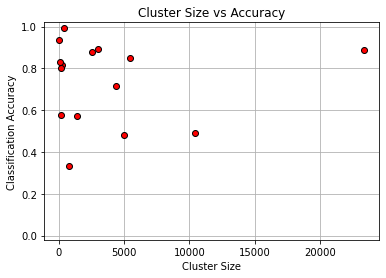

In [46]:
plotClusterSize(gluData,panelWilcoxon[1],gluData.obs["subclass_label"])

C:\Users\mathew.summers\AppData\Local\Temp\ipykernel_15716\1148102767.py:16: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  clAcc = pd.Series( name = "Accuracy")


(<AxesSubplot:title={'center':'Cluster Size vs Accuracy'}, xlabel='Cluster Size', ylabel='Classification Accuracy'>,
                    Count  Accuracy
 TH AV_Col27a1       3011  0.998007
 TH Serpinb7          398  0.974874
 TH PF_Fzd5          2500  0.948000
 TH MH_Tac2          4405  0.936436
 HY Pitx2              83  0.903614
 TH Prkcd_Grin2c    23362  0.866150
 TH PVT_Ntrk1        5419  0.849050
 TH LH_Pou4f1_Sox1   1346  0.774889
 TH Pitx2              30  0.766667
 TH_Rxfp1_Epb4      10411  0.584478
 HY Foxa1             170  0.564706
 TH/HY Gbx2 Fmo1      248  0.564516
 TH/HY Gbx2 Zim1     5006  0.509988
 TH/HY Pth2           170  0.500000
 TH Tfap2d            774  0.268734)

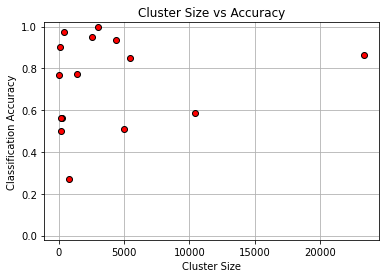

In [43]:
plotClusterSize(gluData,prPanel[15],gluData.obs["subclass_label"])

## Targeted marker selection

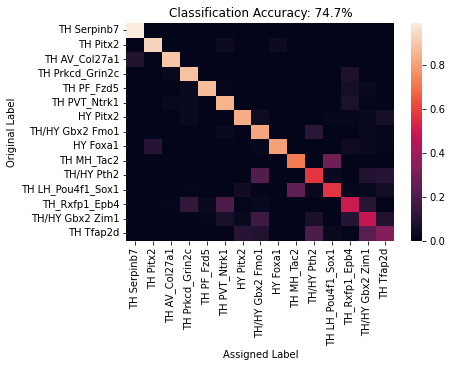

In [184]:
_,_,confMatrix = evalPanel(gluData,panelWilcoxon[1],gluData.obs["subclass_label"])

In [167]:
x = np.argsort(np.diagonal(confMatrix))
confMatrix.iloc[x[0],:] > .05

New Labels
HY Foxa1             False
HY Pitx2              True
TH AV_Col27a1        False
TH LH_Pou4f1_Sox1    False
TH MH_Tac2           False
TH PF_Fzd5           False
TH PVT_Ntrk1         False
TH Pitx2             False
TH Prkcd_Grin2c      False
TH Serpinb7          False
TH Tfap2d             True
TH/HY Gbx2 Fmo1       True
TH/HY Gbx2 Zim1       True
TH/HY Pth2            True
TH_Rxfp1_Epb4        False
Name: TH Tfap2d, dtype: bool

In [133]:
ind = np.unravel_index(np.argmax(confMatrix, axis=None), a.shape)
ind

(0, 1)

In [75]:
sc.tl.rank_genes_groups(gluData, 'subclass_label', method='wilcoxon', groups=["TH/HY Gbx2 Fmo1","TH/HY Gbx2 Zim1","TH/HY Pth2"], reference="TH Tfap2d",pts=True)

In [125]:
# Create a super list dictionary of top marker genes for each subclass, which can be later indexed for specific gene panels
newGenes = {}
for indx in gluData.uns["rank_genes_groups"]["pts"].columns[:-1]:
    genesRanked = pd.DataFrame(
            {key: gluData.uns["rank_genes_groups"][key][indx]
            for key in ['names', 'pvals', 'scores', 'logfoldchanges']})
    pts = gluData.uns["rank_genes_groups"]["pts"][indx][genesRanked.names].reset_index(drop=True).rename("pts")
    pts_rest = gluData.uns["rank_genes_groups"]["pts"]["TH Tfap2d"][genesRanked.names].reset_index(drop=True).rename("pts_rest")
    pts_diff = pd.Series(pts - pts_rest, name="pts_diff")
    genesRanked = pd.concat([genesRanked, pts, pts_rest, pts_diff], axis=1)
    genesRanked = genesRanked.sort_values(by=["scores"], ascending=False, key=abs)
    genesFiltered = genesRanked.iloc[0:500,:]
    genesFiltered = genesFiltered.sort_values(by=["pts_diff"], ascending=False, key=abs)
    newGenes[indx] = genesFiltered["names"][0:32].tolist()
testAdd = getUniqueGenes(newGenes,1)

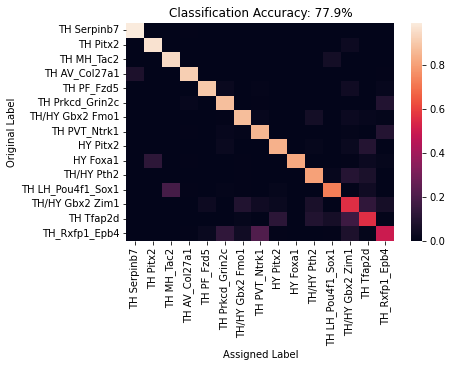

In [185]:
testPanel = np.concatenate((panelWilcoxon[1],testAdd.astype("<U7")))
_,_,_ = evalPanel(gluData,testPanel,gluData.obs["subclass_label"])

In [ ]:
def evalPanel(geneData,genePanel,cluster, showPlot = True):
    """ Function to evaluate the accuracy of a gene panel and plot confusion matrices if requested"""
    from sklearn.neighbors import NearestCentroid
    from scanpy.metrics import confusion_matrix
    import seaborn as sns
    
    # Project data onto input gene panel, then establish a nearest centroid classifier
    projGenes = geneData[:,genePanel].X
    nn = NearestCentroid()
    nn.fit(projGenes,cluster)
    assignedCluster = nn.predict(projGenes)
    accuracy = nn.score(projGenes,cluster)
    # Plot confusion matrix if requested
    if showPlot:
        confMatrix = confusion_matrix(cluster,assignedCluster)
        ax = sns.heatmap(confMatrix)
        ax.set(title="Classification Accuracy: %1.1f%%" %round(accuracy*100,2))
        ax.set(ylabel="Original Label")
        ax.set(xlabel = "Assigned Label")
        return accuracy, ax
    else:
        return accuracy

## Distributions of gene metrics

'TH_Rxfp1_Epb4'

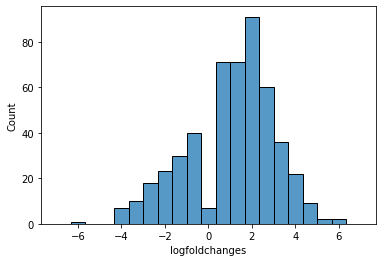

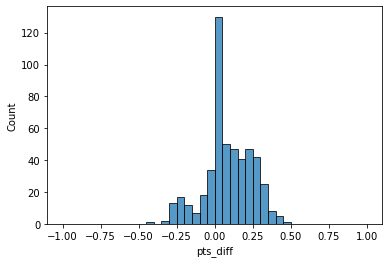

In [11]:
# Distribution of logfoldchanges and percentage differences for one subclass grou
sns.histplot(genesFiltered["logfoldchanges"],binrange=[-7, 7], bins = 'auto')
plt.figure()
sns.histplot(genesFiltered["pts_diff"],binrange=[-1, 1], bins = 40)

## Other stuff

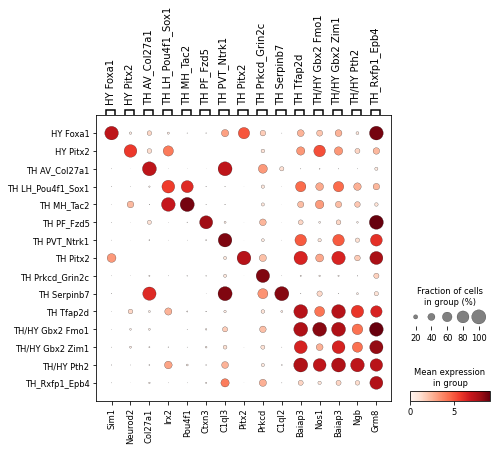

In [547]:
# Create dotplot to visualize potential efficacy of gene panel [used markerGene super set w/ 1 gene each]
sc.pl.dotplot(gluData,markerGenes,"subclass_label")

[Text(0.5, 1.0, '3 Genes')]

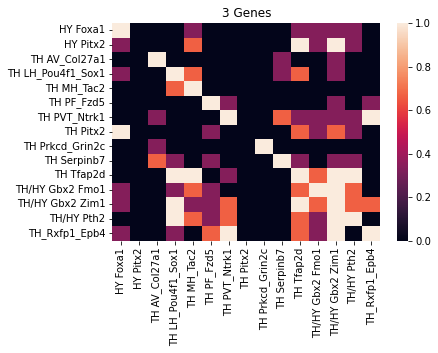

In [193]:
# Plot confusion matrices by "marker gene overlap", e.g. is there any detected expression in a given cell?
pThresh = 1e-10
markerOverlap = sc.tl.marker_gene_overlap(gluData,markerGenes3,method="overlap_count", normalize = "reference", adj_pval_threshold = pThresh, inplace=False)
sns.heatmap(markerOverlap).set(title="3 Genes")

First pass check PROPOSE genes

In [14]:
x = ['C1ql3',
 'Maob',
 'Gucy1a1',
 'Nbl1',
 'Fras1',
 'Caln1',
 'Fam19a4',
 'Zfp536',
 'Fam19a2',
 'Glra3',
 'Cbln1',
 'Unc13c',
 'Zic4',
 'Irx2',
 'Ngb']

(0.7866848063070134,
 <AxesSubplot:title={'center':'Classification Accuracy: 78.7%'}, xlabel='Assigned Label', ylabel='Original Label'>,
 New Labels         HY Foxa1  HY Pitx2  TH AV_Col27a1  TH LH_Pou4f1_Sox1  \
 subclass_label                                                            
 HY Foxa1           0.623529  0.041176       0.005882           0.011765   
 HY Pitx2           0.036145  0.891566       0.000000           0.000000   
 TH AV_Col27a1      0.000000  0.000000       0.999004           0.000000   
 TH LH_Pou4f1_Sox1  0.020802  0.008915       0.003715           0.693165   
 TH MH_Tac2         0.001589  0.000227       0.000000           0.012259   
 TH PF_Fzd5         0.001600  0.000000       0.010800           0.002000   
 TH PVT_Ntrk1       0.005167  0.000000       0.000185           0.000000   
 TH Pitx2           0.000000  0.000000       0.000000           0.000000   
 TH Prkcd_Grin2c    0.002568  0.000086       0.030177           0.000214   
 TH Serpinb7        0.00502

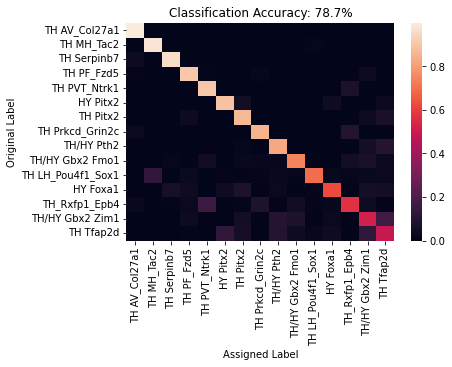

In [21]:
evalPanel(gluData,x,gluData.obs["subclass_label"])

## Intersection of gene panels

In [21]:
x = set(panelWilcoxon[4])
y = set(prPanel[60])
z = set(gfPanel["4"])

In [25]:
len(y)

60

## Gene search
Regular expression exercise to try and find particular genes

In [8]:
gluData.var_names

Index(['Xkr4', 'Rp1', 'Sox17', 'Mrpl15', 'Lypla1', 'Tcea1', 'Rgs20', 'Atp6v1h',
       'Oprk1', 'Npbwr1',
       ...
       'AC125149.1', 'AC125149.2', 'AC125149.4', 'AC234645.1', 'AC168977.2',
       'AC168977.1', 'AC149090.1', 'CAAA01118383.1', 'Vmn2r122',
       'CAAA01147332.1'],
      dtype='object', name='gene', length=23431)

In [10]:
# import re
p  = re.compile('Rik', re.IGNORECASE)
myList = gluData.var_names
newList = list(filter(p.search, myList))
newList

['4732440D04Rik',
 '3110035E14Rik',
 '1700034P13Rik',
 'A830018L16Rik',
 '4930444P10Rik',
 'D030040B21Rik',
 '4930486I03Rik',
 '6720483E21Rik',
 '4933415F23Rik',
 '4931408C20Rik',
 '4931428L18Rik',
 '4930568A12Rik',
 '1700101I19Rik',
 '1110002O04Rik',
 '4930535G08Rik',
 '4930403P22Rik',
 '4933424G06Rik',
 '4930439A04Rik',
 '2010300C02Rik',
 '4930556I23Rik',
 'D930019O06Rik',
 '1700066B17Rik',
 '4930448I06Rik',
 '8430432A02Rik',
 '1500015O10Rik',
 '4930521E06Rik',
 'C230029F24Rik',
 '4933411E06Rik',
 '9330175M20Rik',
 '1700072G22Rik',
 '1700019D03Rik',
 '1700019A02Rik',
 '4930444A19Rik',
 '9130227L01Rik',
 '1700003I22Rik',
 '1700126A01Rik',
 '4930558J18Rik',
 '1700066M21Rik',
 'G730003C15Rik',
 '1700122D07Rik',
 '2310016D23Rik',
 '9530026F06Rik',
 '4930587A21Rik',
 '4933402D24Rik',
 'D630023F18Rik',
 '4933417E11Rik',
 '4930556G22Rik',
 'D230017M19Rik',
 '1700027A15Rik',
 'D530049I02Rik',
 'C530043A13Rik',
 '6030407O03Rik',
 'A630095N17Rik',
 '5730419F03Rik',
 '9830004L10Rik',
 '2310015K

In [11]:
len(newList)

2182

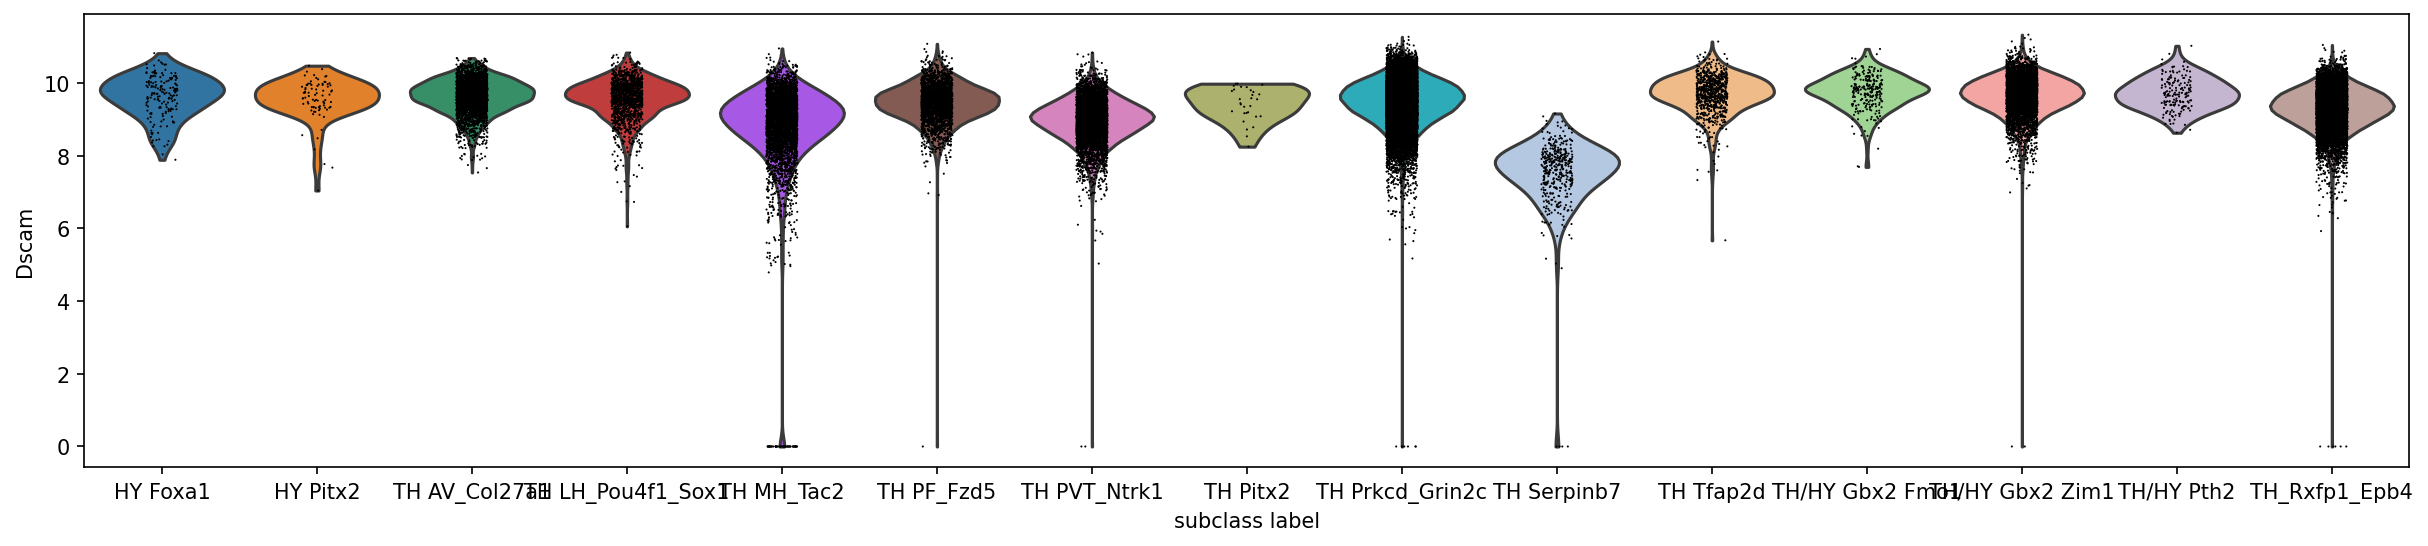

In [10]:
plt.figure(figsize=(20, 4), dpi=150)
ax = plt.subplot(1,1, 1)
sc.pl.violin(gluData,"Dscam",groupby="subclass_label", ax = ax)

In [ ]:
# List of cell adhesion genes
# Lrrtm, Cbln, Pcdh, Cdh, Nrxn, Celsr, NCAM, Xpr1, Nphs, Lrfn, Sall, EphB, NGL(?), DSCAM

# adhesionGenes = ["Lrrtm1","Lrrtm2","Lrrtm3","Lrrtm4","Cbln1","Cbln2","Cbln3","Clbn4"]